In [1]:
import numpy as np
from matplotlib import pyplot as plt

from random import randint as rnd

from PIL import Image

from scipy.io import loadmat
from scipy.special import expit

In [2]:
#displays random k*k digits from dataset
def show_data(X, k=10):
    m, n = np.shape(X)
    
    mat = X[rnd(0, m - 1),:].reshape((20, 20)).T
    
    for _ in range(k - 1):
        mat = np.append(mat, X[rnd(0, m - 1),:].reshape((20, 20)).T, axis=1)
    
    for _ in range(k - 1):
        tmp = X[rnd(0, m - 1),:].reshape((20, 20)).T
        for _ in range(k - 1):
            tmp = np.append(tmp, X[rnd(0, m - 1),:].reshape((20, 20)).T, axis=1)
        
        mat = np.append(mat, tmp, axis=0)
    
    im = Image.fromarray(mat * 255)
    imr = im.resize((500, 500), Image.ANTIALIAS)
    plt.imshow(np.asarray(imr), cmap='Greys_r')
    plt.show()

In [3]:
#displays 25 weights of first layer
def visualize_weights(W):
    m, n = np.shape(W)
    k = 5
    
    mat = W[0,:].reshape((20, 20)).T
    
    for i in range(1, k):
        mat = np.append(mat, W[i,:].reshape((20, 20)).T, axis=1)
    
    for i in range(1, k):
        tmp = W[i * k, :].reshape((20, 20)).T
        for j in range(1, k):
            tmp = np.append(tmp, W[i * k + j, :].reshape((20, 20)).T, axis=1)
        
        mat = np.append(mat, tmp, axis=0)
    
    im = Image.fromarray(mat * 255)
    imr = im.resize((500, 500), Image.ANTIALIAS)
    plt.imshow(np.asarray(imr), cmap='Greys_r')
    plt.show()

In [4]:
#sigmoid function
def g_sigm(z):
    return expit(z) * (1 - expit(z))

In [15]:
#makes prediction for given examples with computed thetas
def predict_nn(theta1, theta2, X):
    
    z2 = np.dot(theta1, X.T)
    a2 = np.append(np.ones((1, np.shape(z2)[1])), expit(z2), axis=0)
    
    z3 = np.dot(theta2, a2)
    a3 = expit(z3)
    
    return a3

In [6]:
#computes loss and gradients for one iteration of 
#neural network learning process
def iteration_nn(theta1, theta2, X, y, lmbd, m):
    #compute loss
    #############
    z2 = np.dot(theta1, X.T)
    a2 = np.append(np.ones((1, m)), expit(z2), axis=0)
    
    a3 = expit(np.dot(theta2, a2))
    
    J = np.sum(- np.sum(y * np.log(a3.T), axis=1) - np.sum((1 - y) * np.log(1 - a3.T), axis=1))
    
    J = J / m + lmbd * (np.sum(np.square(theta1)) + np.sum(np.square(theta2))) / (2 * m)
    
    
    #compute gradients
    #############
    delta3 = a3 - y.T 
    
    g_theta1 = np.zeros(np.shape(theta1))
    g_theta2 = np.zeros(np.shape(theta2))
    
    for i in range(m):
        g_theta2 = g_theta2 + np.dot(delta3[:, i].reshape(10,1), a2[:, i].reshape(1,26)) 
    
        delta2 = np.dot(theta2.T, delta3[:, i].reshape(10, 1))[1:,:] * g_sigm(z2[:, i].reshape(25, 1))
        
        g_theta1 = g_theta1 + np.dot(delta2, X[i, :].reshape(1, 401)) 
    
    
    g_theta1[:, 1:] = g_theta1[:, 1:] + lmbd * theta1[:, 1:] 
    g_theta2[:, 1:] = g_theta2[:, 1:] + lmbd * theta2[:, 1:]     
    
    return J, g_theta1 / m, g_theta2 / m

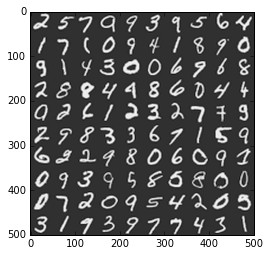

In [7]:
#load data
data = loadmat('mnist.mat')
xy = np.append(data['X'], data['y'], axis=1)

#randomly shuffle examples
np.random.shuffle(xy)

X = xy[:,:-1]
y = xy[:, -1]

#show 100 digits in grid
show_data(X, k=10)

In [8]:
#map new labels to every sample
d = {10: [0,0,0,0,0,0,0,0,0,1], 
     1: [1,0,0,0,0,0,0,0,0,0],
     2: [0,1,0,0,0,0,0,0,0,0],
     3: [0,0,1,0,0,0,0,0,0,0],
     4: [0,0,0,1,0,0,0,0,0,0],
     5: [0,0,0,0,1,0,0,0,0,0],
     6: [0,0,0,0,0,1,0,0,0,0],
     7: [0,0,0,0,0,0,1,0,0,0],
     8: [0,0,0,0,0,0,0,1,0,0],
     9: [0,0,0,0,0,0,0,0,1,0]}

y_labels = np.array([d[i] for i in y])

In [9]:
#randomly initialize weights
e_init = 0.12
theta1 = np.random.uniform(-e_init, e_init, 10025).reshape(25, 401)
theta2 = np.random.uniform(-e_init, e_init, 260).reshape(10, 26)

#set lambda and learning rate
lmbd = 0.5
alpha = 0.05

m_all = np.shape(X)[0]
m_train = int(m_all * 0.7)

#add column of ones for bias
nX = np.append(np.ones((m_all,1)), X, axis=1)

#retrieve training examples from dataset
X_train = nX[:m_train, :]
y_train = y_labels[:m_train, :]

#set number of training iterations 
#and initialize array to store errors
iters = 3000
history = np.zeros((iters,))

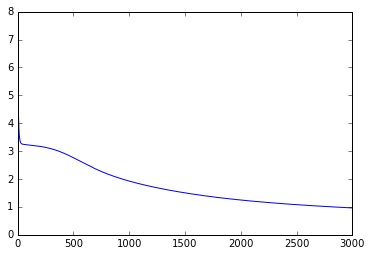

In [11]:
#main loop of algorithm
for i in range(iters):
    j, g1, g2 = iteration_nn(theta1, 
                             theta2, 
                             X_train,
                             y_train,
                             lmbd,
                             m_train)
    history[i] = j
    theta1 = theta1 - alpha * g1
    theta2 = theta2 - alpha * g2


#save computed thetas
np.savetxt("theta1.csv", theta1, delimiter=",")
np.savetxt("theta2.csv", theta2, delimiter=",")

#show learning curve
plt.plot(history)
plt.show()

In [32]:
#evaluate computed weights on unseen data from test set
predictions = predict_nn(theta1, theta2, nX[m_train:, :])
ac = 100 * np.count_nonzero(np.argmax(predictions, axis=0) - y[m_train:]) / (m_all - m_train)

print("Accuracy: {:3.2f}%".format(ac))

Accuracy: 99.27%


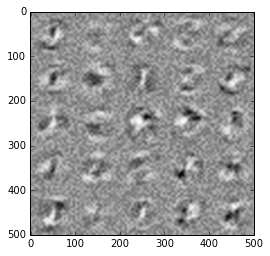

In [18]:
visualize_weights(theta1[:, 1:])